# Discovering Causal Relationships through Gradient Learning

Imagine you've collected data on student study hours, sleep patterns, and exam scores. You notice correlations between these variables, but correlation doesn't imply causation which is a fundamental challenge in data analysis. Does more studying cause better exam performance? Does sleep quality affect study efficiency? Or do other factors drive these relationships?

Unlike standard machine learning that focuses on prediction, causal inference seeks to understand the underlying mechanisms: what causes what.

Traditionally, establishing causality required controlled experiments where we manipulate variables and observe outcomes. But what if experiments are impossible, unethical, or too expensive? Can we infer causality from observational data alone?

Approaches differ from constraint-based methods (like the PC algorithm) that test conditional independence, and score-based methods that search for graph structures optimizing certain criteria. Both approaches face a fundamental hurdle: learning a Directed Acyclic Graph (DAG) is a combinatorial optimization problem with a super-exponential search space ie. there are $2^(n^2)$ possible edge configurations for n variables.

# The Challenge
## Learning Dags from data
Simplistically at it's core the problem is about finding a Directed Acyclic Graph (DAG) from a data generating process. A node would represent a variable, and the edge would represent the relationship. The edge is weighted to represent the strength of the relationship.

## Traditional Approaches and Their Limitations
Previous methods for causal discovery generally fall into two categories:
1. Constraint-Based Methods (like PC and FCI algorithms):

- Test conditional independence between variables
- Build a graph consistent with these independence relationships
- **Advantages**: Require fewer assumptions about the data distribution
- **Limitations**: Sensitive to errors in independence tests, especially with limited data

2. Score-Based Methods (like GES and various Bayesian approaches):

- Define a score function that measures how well a graph explains the data
- Search through the space of possible graphs to maximize this score
- **Advantages**: Can incorporate prior knowledge and handle uncertainty
- **Limitations**: The search space grows super-exponentially with the number of variables

Both of these class of approaches as discussed by the paper struggle with one thing: *ensuring dag acyclicity*. The space of all possible graph is large but only a fraction are acyclic.


In [1]:
import numpy as np
import networkx as nx

from utils import timing


def generate_random_dag(d, s0):
    """Generate a random DAG with d nodes and s0 expected edges."""
    # Create a random lower triangular matrix with random weights
    A = np.zeros((d, d))
    for i in range(d):
        for j in range(i):
            if np.random.rand() < s0/(d-1):
                A[j, i] = np.random.uniform(0.5, 2.0) * np.random.choice([-1, 1])

    # Randomly permute the nodes to get a random DAG
    P = np.random.permutation(np.eye(d))
    A = P.T @ A @ P

    return A

def generate_sem_data(W, n, noise_scale=1.0):
    """Generate data from a linear SEM X = XW + Z."""
    d = W.shape[0]
    I = np.eye(d)
    Z = np.random.normal(0, noise_scale, size=(n, d))

    # For NOTEARS, we need W where W[i,j] means j→i
    W_notears = W.T

    # Use matrix form: X = (I-W')^(-1)Z  (where W' is in NOTEARS convention)
    X = Z @ np.linalg.inv(I - W_notears.T)

    return X, W_notears

In [2]:
np.random.seed(42)
nodes, edges = 5, 2
samples = 1000
A = generate_random_dag(nodes, edges)
X, W_notears = generate_sem_data(A, 1000)
A

array([[ 0.        ,  0.        ,  0.        ,  1.95486478,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.98831734,  0.        ],
       [-1.92607146, -0.64996237,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

(<networkx.classes.digraph.DiGraph at 0x1112973d0>,
 {0: array([0.12251029, 0.49037805]),
  1: array([0.57577586, 0.09884114]),
  2: array([-0.35022361, -1.        ]),
  3: array([-0.75018389,  0.11492044]),
  4: array([0.40212136, 0.29586037])},
 <Axes: title={'center': 'DAG'}>)

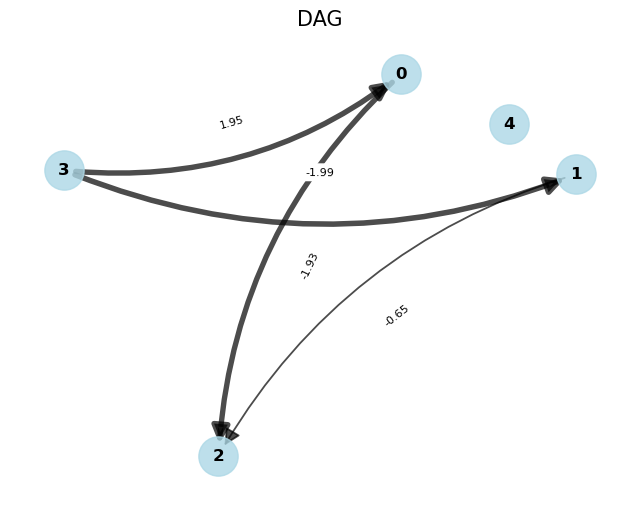

In [3]:
from utils import visualize_dag

visualize_dag(W_notears)

The following dag represents causal relationships where the nodes are the variables we're exploring and the arrows indicate the direction to where the variable directly causes or effects the other. The edge weights represent the strength of the causal effect. A positive increase in cause increase in effect whilst a negative means increase in cause decrease in effect.

Relationships in this toy example:

- X3 has a negative effect (-1.93) on X1
- X3 has a positive effect (1.95) on X0
- X0 influences X2 with a negative effect (-1.99)
- X1 has a small negative effect (-0.65) on X2
- X4 appears isolated (no edges connecting to it)

In layman's terms this could mean
- X3 could be considered a "common cause" for X2, X3, and X0
- X4 is independent of the other variables (a confounding variable that wasn't detected or has no relationship)

This scenario is ideal for this algorithm to work because:
- It has no cycles
- Weighted edges representing the strength of causal effects
- A mix of relationships (some variables with multiple parents/children, some isolated)

## Benchmark

Before diving into the implementation, it's valuable to understand how NOTEARS compares to traditional causal discovery approaches. This comparison helps illustrate why gradient-based methods represent such a significant advancement in the field.


In [4]:
from causallearn.search.ScoreBased.GES import ges
from causallearn.search.ConstraintBased.PC import pc

from utils import plot_dag_comparison

@timing
def run_ges(X):
    cg = ges(X, score_func="local_score_BIC")
    G = cg['G'].graph
    # Convert to adjacency matrix
    return nx.to_numpy_array(nx.DiGraph(G))

@timing
def run_pc(X):
    record = pc(X, score_func="local_score_BIC")
    G = record.G.graph
    # Convert to adjacency matrix
    return nx.to_numpy_array(nx.DiGraph(G))

W_est_ges, time_taken_ges = run_pc(X)

/opt/homebrew/Caskroom/mambaforge/base/envs/notears/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 1820.92it/s]

func:'run_pc' args:[(array([[ 0.22586728,  0.09601459, -1.01283112,  0.56487985, -0.90802408],
       [-0.97744241,  1.61239487, -0.2257763 , -5.04919222, -1.42474819],
       [ 1.67251316,  0.85902511, -1.15099358,  1.93722056, -0.60063869],
       ...,
       [ 0.02524238, -0.12905757, -0.45341411, -1.48969033, -0.33009019],
       [-1.28662343, -1.95570639,  1.04848265,  1.86116493, -0.73423332],
       [-1.55439515,  1.12154333,  0.73354781, -5.25983271, -0.23768332]],
      shape=(1000, 5)),), {}] took: 0.0223 sec


(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'True DAG'}>,
        <Axes: title={'center': 'Estimated DAG'}>], dtype=object),
 {0: array([0.12251029, 0.49037805]),
  1: array([0.57577586, 0.09884114]),
  2: array([-0.35022361, -1.        ]),
  3: array([-0.75018389,  0.11492044]),
  4: array([0.40212136, 0.29586037])})

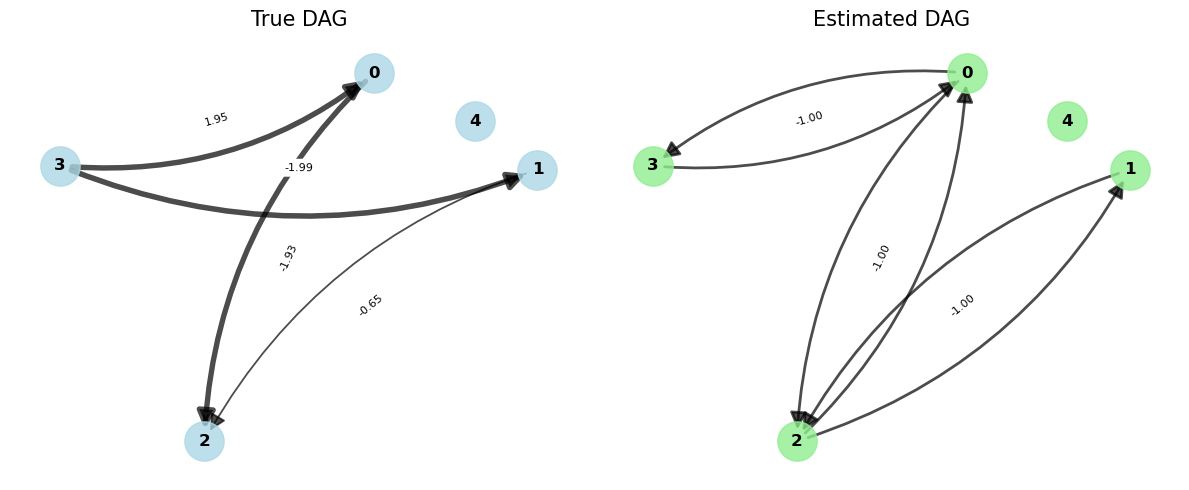

In [5]:
plot_dag_comparison(W_notears, W_est_ges)

### What PC Got Right

1. **Correct Edge Detection**: PC successfully identified several true causal relationships:

- The connection between nodes 3 and 0 (though the direction is uncertain)
- The relationship involving node 2 as a hub/sink
- *Some* of the connections to node 1

2. **Sparsity**: PC maintained a reasonable level of sparsity, avoiding the creation of an overly dense graph

### Limitations

1. **Missing edges**
- Teh algorithm missed the edge from 3→1 (weight of -1.93)
2. **Edge Direction**
- This is a fundamental limitation of methods like PC and GES
- PC can only orient edges when there are clear v-structures (X→Z←Y) or other identifiable patterns
- Many edges remain unoriented or may be incorrectly oriented due to insufficient statistical power
3. **Strength of Casual Realtionship**
- PC performs conditional independence tests that return binary results (independent/dependent)
- It builds the graph by deciding whether edges exist or not, without estimating effect strengths

### Why these differences?
These differences happen for a number of reasons:
1. **Statistical Testing Limitations:**

- PC relies on conditional independence tests, which can fail with:
    - Limited sample sizes
    - Weak relationships (small effect sizes)
    - Non-linear relationships (even mild ones)
2. **Multiple testing**
- PC performs many statistical tests, increasing the chance of false positives

Before explaining and implementing the no tears algorithm lets run a few scenarios to highlight the problems with the PC algorithm further. I'm going to import the evaluate_reconstruction function from my utils module which will calculate several important plots and metrics.

#### Performance Metrics
From the confusion matrix we can get
- TP - True Positive: Correctly identified edges that actually exist
- FP - False Positive: Incorrectly identified edges that don't actually exist
- FN - False Negative: Missed edges that actually exist
- TN - True Negative: Correctly identified absence of edges

From these results we can calculate the:
- Precision: Is the fraction of correct edges $P = \frac{tp}{tp+fp}$
- Recall: Is the fraction of relevant edges that were retrieved $R = \frac{tp}{tp+fn}$
- F1 score: The harmonic mean between precision and recall $F1 = 2 \cdot \frac{P \cdot R}{P + R}$

We can also compute the Structural Hamming Distance (SHD) which is a standard distance to compare graphs by their adjacency matrix.

#### Performance Plots
##### Left Plot: True DAG Structure (Binary Adjacency Matrix)
- Dark blue squares: Indicate true causal relationships (edges exist)
- White squares: No causal relationship exists
- Reading: If there's a dark square at position (i,j), it means variable j causes variable i

##### Middle Plot: Estimated DAG Structure
- Shows what the PC algorithm discovered
- Dark blue squares: Edges the PC algorithm detected
- White squares: No relationship detected by PC

#### Right Plot: Edge Recovery Analysis
This is a confusion matrix showing the algorithm's performance:

- Blue (TP - True Positive)
- Green (FP - False Positive)
- Red (FN - False Negative)
- White (TN - True Negative)


Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 2250.16it/s]


func:'run_pc' args:[(array([[ 2.25867282e-01,  9.60145899e-02, -1.01283112e+00,
         5.64879852e-01, -9.08024076e-01],
       [-9.77442413e-01,  1.61239487e+00, -2.25776300e-01,
        -5.04919222e+00, -1.42474819e+00],
       [ 1.67251316e+00,  8.59025107e-01, -1.15099358e+00,
         1.93722056e+00, -6.00638690e-01],
       [-3.85931390e+00, -1.80561774e+00,  1.85227818e+00,
        -3.96779297e+00, -1.05771093e+00],
       [ 4.20258703e-01, -1.35659713e+00,  2.08863595e-01,
         1.55922440e+00, -1.32818605e+00],
       [-1.33206320e-01,  6.27083645e-01,  1.71368281e-01,
        -1.62288991e+00, -3.01103696e-01],
       [-5.91298800e-01, -4.20446339e-01, -4.60638771e-01,
         7.37193775e-01,  3.43618290e-01],
       [-1.02134417e+00,  5.74372962e-01, -3.85082280e-01,
        -3.81554746e+00,  6.11676289e-01],
       [ 2.64739244e+00,  1.47673993e+00, -8.39217523e-01,
         1.92985425e+00,  3.31263431e-01],
       [ 1.33313758e+00, -3.58502889e-01, -1.85658977e-01,
  

Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 2350.80it/s]


func:'run_pc' args:[(array([[ 0.22586728,  0.09601459, -1.01283112,  0.56487985, -0.90802408],
       [-0.97744241,  1.61239487, -0.2257763 , -5.04919222, -1.42474819],
       [ 1.67251316,  0.85902511, -1.15099358,  1.93722056, -0.60063869],
       ...,
       [-1.52474155, -0.0586706 ,  0.96818466, -3.19531615, -0.61223673],
       [-6.76531713, -2.74221094,  2.94909443, -6.52821503, -1.35107437],
       [-2.37652906,  0.12616453,  0.5472648 , -4.34776426, -0.25495579]],
      shape=(500, 5)),), {}] took: 0.0109 sec


Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 2244.14it/s]


func:'run_pc' args:[(array([[ 0.22586728,  0.09601459, -1.01283112,  0.56487985, -0.90802408],
       [-0.97744241,  1.61239487, -0.2257763 , -5.04919222, -1.42474819],
       [ 1.67251316,  0.85902511, -1.15099358,  1.93722056, -0.60063869],
       ...,
       [ 0.02524238, -0.12905757, -0.45341411, -1.48969033, -0.33009019],
       [-1.28662343, -1.95570639,  1.04848265,  1.86116493, -0.73423332],
       [-1.55439515,  1.12154333,  0.73354781, -5.25983271, -0.23768332]],
      shape=(1000, 5)),), {}] took: 0.0109 sec


Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 1993.68it/s]


func:'run_pc' args:[(array([[ 0.22586728,  0.09601459, -1.01283112,  0.56487985, -0.90802408],
       [-0.97744241,  1.61239487, -0.2257763 , -5.04919222, -1.42474819],
       [ 1.67251316,  0.85902511, -1.15099358,  1.93722056, -0.60063869],
       ...,
       [ 0.02524238, -0.12905757, -0.45341411, -1.48969033, -0.33009019],
       [-1.28662343, -1.95570639,  1.04848265,  1.86116493, -0.73423332],
       [-1.55439515,  1.12154333,  0.73354781, -5.25983271, -0.23768332]],
      shape=(1000, 5)),), {}] took: 0.0129 sec


[{'n_samples': 100, 'f1': np.float64(0.5)},
 {'n_samples': 500, 'f1': np.float64(0.6)},
 {'n_samples': 1000, 'f1': np.float64(0.6)},
 {'n_samples': 2000, 'f1': np.float64(0.6)}]

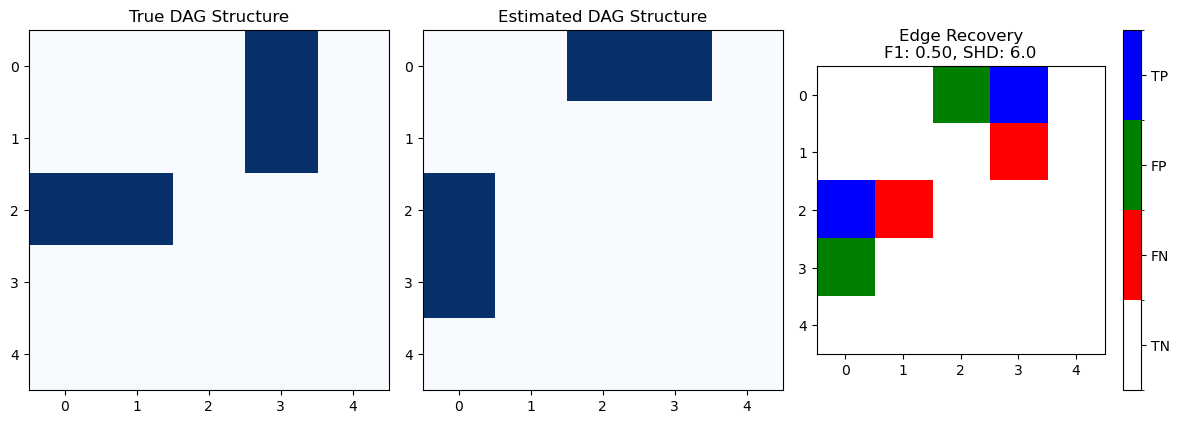

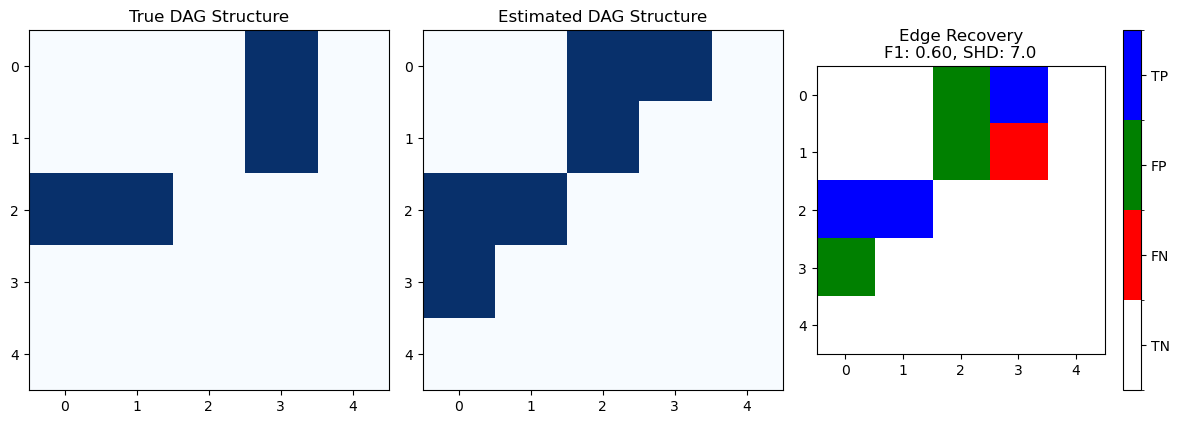

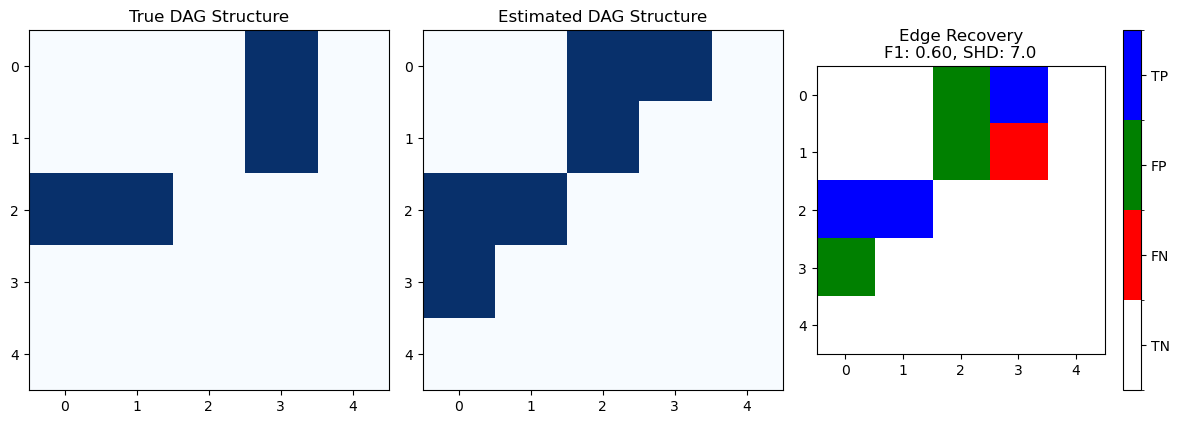

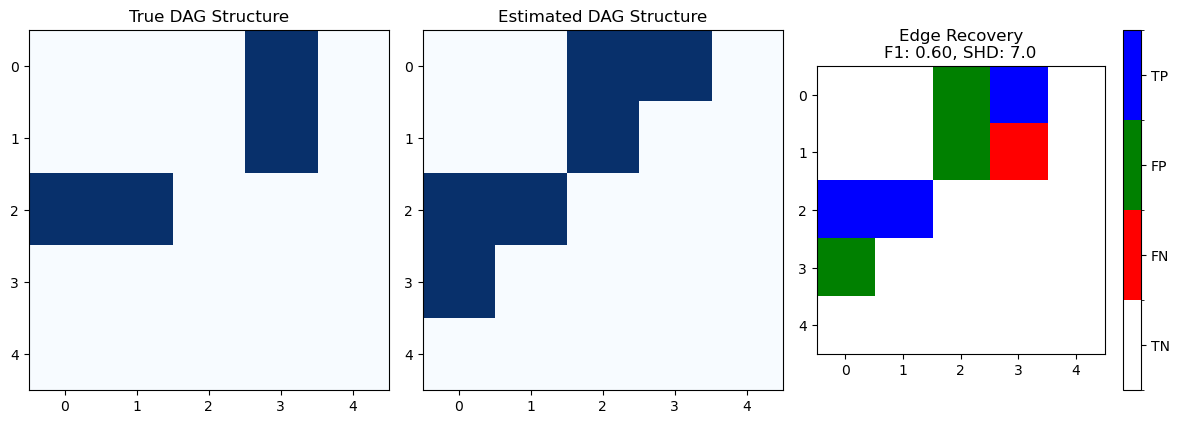

In [6]:
from utils import evaluate_reconstruction

def analyze_sample_size_effects():
    sample_sizes = [100, 500, 1000, 2000]
    results = []

    for n in sample_sizes:
        X_subset = X[:n, :]  # Use first n samples
        W_pc, _ = run_pc(X_subset)
        metrics = evaluate_reconstruction(W_notears, W_pc)
        results.append({
            'n_samples': n,
            'f1': metrics['f1']
        })

    return results
analyze_sample_size_effects()

The PC algorithm faired moderately well on this graph structure and varying data points. The f1 metrics ranged between 0.5 and 0.6
However it missed important edges, the failure to detect 3→1 could be crucial in real applications
There are also a number of important false discoveries and the green squares show PC is adding edges that don't exist. These could be potentially misleading.

## NOTEARS
NOTEARS (NonParametric Estimation of Acyclic diREcted graphS) introduced a remarkably elegant solution to reduce the search space: reformulate the acyclicity constraint as a differentiable function of the weight matrix W:
$$
h(W) = tr(e^{(W \cdot W)}) - d = 0
$$
where:
- tr() is the trace operator (sum of diagonal elements)
- $e^{(W \cdot W)}$ is the matrix exponential of the Hadamard element-wise product
- d is the number of variables

In [ ]:
import jax
from jax import numpy as jnp
import scipy.optimize as sopt
from functools import partial
from jax import jit, value_and_grad


@jit
def h_acyclic(W):
    """
    Calculate the acyclicity constraint value.
    :param W: the weight data matrix W
    :return:
    """
    d = W.shape[0]
    E = jax.scipy.linalg.expm(W * W)
    return jnp.trace(E) - d

@jit
def l2_loss(X, W):
    """
    Calculate L2 loss between data X and model X@W.
    :param X: the input matrix
    :param W: the weight matrix
    :return: the l2 loss between X@W
    """
    M = X @ W
    R = X - M
    return 0.5 / X.shape[0] * jnp.sum(R ** 2)

@partial(jit, static_argnums=(1,))
def _adj(w, d):
    """
    Convert doubled variables [w_pos, w_neg] to weight matrix W = w_pos - w_neg.

    NOTEARS uses a trick to handle both positive and negative edge weights while
    maintaining non-negativity constraints during optimization. Each edge weight
    W[i,j] is represented as w_pos[i,j] - w_neg[i,j] where both w_pos and w_neg
    are constrained to be non-negative.

    Parameters
    ----------
    w : jax.numpy.ndarray
        Flattened weight vector of length 2*d^2, containing [w_pos.flatten(), w_neg.flatten()]
    d : int
        Number of variables (nodes) in the DAG. Must be static for JIT compilation.

    Returns
    -------
    jax.numpy.ndarray
        Weight matrix W of shape (d, d) where W[i,j] represents the causal effect
        of variable j on variable i
    """
    d_squared = d * d
    w_pos = w[:d_squared].reshape((d, d))
    w_neg = w[d_squared:].reshape((d, d))
    return w_pos - w_neg

@partial(jit, static_argnums=(2,))
def augmented_lagrangian(w, X, d, alpha, rho, lambda1):
    """
    Compute the augmented Lagrangian objective.
    :param w:
    :param X:
    :param d:
    :param alpha:
    :param rho:
    :param lambda1:
    :return:
    """
    W = _adj(w, d)
    loss = l2_loss(X, W)
    h = h_acyclic(W)
    return loss + 0.5 * rho * h * h + alpha * h + lambda1 * jnp.sum(w)

# Create compiled value_and_grad function
aug_lagrangian_with_grad = value_and_grad(augmented_lagrangian, argnums=0)
aug_lagrangian_with_grad = partial(jit, static_argnums=(2,))(aug_lagrangian_with_grad)

In [ ]:
def create_dag_bounds(d):
    """
    Create bounds for the optimization variables in the doubled-variable formulation.

    In NOTEARS, each weight W[i,j] is represented as w_pos[i,j] - w_neg[i,j] where
    both w_pos and w_neg are non-negative. This function creates bounds for the
    flattened vector [w_pos.flatten(), w_neg.flatten()].

    Parameters
    ----------
    d : int
        Number of variables (nodes) in the DAG

    Returns
    -------
    list of tuple
        List of (min, max) bounds for each optimization variable.
        Length is 2*d^2. Diagonal elements are bounded to (0,0) to prevent
        self-loops, off-diagonal elements are bounded to (0, None).
    """
    bounds = []
    for k in range(2):  # For w_pos and w_neg
        for i in range(d):
            for j in range(d):
                if i == j:
                    bounds.append((0, 0))  # No self-loops
                else:
                    bounds.append((0, None))  # Non-negative weights
    return bounds

def create_scipy_wrapper(w, X, d, alpha, rho, lambda1):
    """
    Create a wrapper function for scipy optimizer that converts between JAX and NumPy.

    SciPy's optimizers expect NumPy arrays and return NumPy arrays, while our
    JAX implementation uses JAX arrays. This wrapper handles the conversion.

    Parameters
    ----------
    w : jax.numpy.ndarray
        Current weight vector (used for function signature, not actual computation)
    X : jax.numpy.ndarray
        Data matrix of shape (n_samples, n_variables)
    d : int
        Number of variables (nodes) in the DAG
    alpha : float
        Lagrange multiplier for the acyclicity constraint
    rho : float
        Penalty parameter for the augmented Lagrangian
    lambda1 : float
        L1 regularization strength

    Returns
    -------
    callable
        Function that takes NumPy array and returns (objective_value, gradient)
        suitable for SciPy's minimize function with jac=True
    """
    def scipy_obj_and_grad(w_np):
        w_jax = jnp.array(w_np)
        obj, grad = aug_lagrangian_with_grad(w_jax, X, d, alpha, rho, lambda1)
        return float(obj), np.array(grad)
    return scipy_obj_and_grad

def optimize_weights(w_est, X, d, alpha, rho, lambda1, bounds):
    """
    Perform one step of L-BFGS-B optimization for the augmented Lagrangian.

    This function wraps SciPy's L-BFGS-B optimizer to solve the constrained
    optimization problem in NOTEARS using the augmented Lagrangian method.

    Parameters
    ----------
    w_est : jax.numpy.ndarray
        Current estimate of the weight vector (length 2*d^2)
    X : jax.numpy.ndarray
        Data matrix of shape (n_samples, n_variables)
    d : int
        Number of variables (nodes) in the DAG
    alpha : float
        Lagrange multiplier for the acyclicity constraint
    rho : float
        Penalty parameter for the augmented Lagrangian
    lambda1 : float
        L1 regularization strength
    bounds : list of tuple
        Bounds for each optimization variable from create_dag_bounds()

    Returns
    -------
    jax.numpy.ndarray
        Optimized weight vector of length 2*d^2

    Notes
    -----
    Uses L-BFGS-B which is a quasi-Newton method that handles box constraints
    efficiently. The method is well-suited for the smooth optimization problems
    arising in the augmented Lagrangian formulation.
    """
    # Convert to numpy for scipy
    w_np = np.array(w_est)

    # Create the objective function wrapper
    obj_func = create_scipy_wrapper(w_est, X, d, alpha, rho, lambda1)

    # Run L-BFGS-B optimization
    result = sopt.minimize(
        obj_func, w_np, method='L-BFGS-B',
        jac=True, bounds=bounds
    )

    # Return JAX array
    return jnp.array(result.x)

def threshold_weights(W, threshold):
    """
    Apply thresholding to remove small edges from the estimated DAG.

    Sets edge weights with absolute value below the threshold to exactly zero.
    This is a common post-processing step in causal discovery to produce
    sparse graphs and remove weak, potentially spurious connections.

    Parameters
    ----------
    W : jax.numpy.ndarray
        Weight matrix of shape (d, d) representing the DAG
    threshold : float
        Minimum absolute weight value to retain. Edges with |weight| < threshold
        are set to zero

    Returns
    -------
    jax.numpy.ndarray
        Thresholded weight matrix with the same shape as W

    Examples
    --------
    >>> W = jnp.array([[0, 0.8, 0.02], [0, 0, 0.5], [0, 0, 0]])
    >>> threshold_weights(W, 0.1)
    Array([[0. , 0.8, 0. ],
           [0. , 0. , 0.5],
           [0. , 0. , 0. ]], dtype=float32)
    """
    return jnp.where(jnp.abs(W) < threshold, 0, W)

In [5]:
@timing
def notears_linear(X, lambda1=0.1, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """
    Learn a DAG from data using the NOTEARS algorithm.

    Args:
        X (ndarray): [n, d] data matrix
        lambda1 (float): L1 regularization parameter
        max_iter (int): Maximum number of dual ascent steps
        h_tol (float): Exit if |h(W)| <= h_tol
        rho_max (float): Exit if rho >= rho_max
        w_threshold (float): Remove edges with |weight| < threshold

    Returns:
        W_est (ndarray): [d, d] estimated DAG
    """
    # Setup
    n, d = X.shape
    X = X - jnp.mean(X, axis=0)  # Center the data

    # Initialize parameters
    w_est = jnp.zeros(2 * d * d)  # [w_pos, w_neg]
    rho, alpha, h = 1.0, 0.0, jnp.inf

    # Create bounds for optimization
    bounds = create_dag_bounds(d)

    # Augmented Lagrangian optimization
    for i in range(max_iter):
        # Inner optimization
        w_new = None
        inner_converged = False

        while rho < rho_max and not inner_converged:
            # Optimize weights
            w_new = optimize_weights(w_est, X, d, alpha, rho, lambda1, bounds)

            # Check acyclicity
            W_new = _adj(w_new, d)
            h_new = h_acyclic(W_new)

            # Update penalty parameter if needed
            if h_new > 0.25 * h:
                rho *= 10
            else:
                inner_converged = True

        # Update estimates
        w_est = w_new
        h = h_acyclic(_adj(w_est, d))
        alpha += rho * h

        # Log progress
        print(f"Iteration {i}: h={h:.6e}, rho={rho:.2e}")

        # Check convergence
        if h <= h_tol or rho >= rho_max:
            break

    # Final processing
    W_est = _adj(w_est, d)

    # Thresholding
    W_est = jnp.where(jnp.abs(W_est) < w_threshold, 0, W_est)

    print(f"Final h(W): {h_acyclic(W_est):.6e}")

    # Transpose to get standard adjacency matrix where W[i,j]≠0 means i→j
    W_est = W_est.T

    return W_est



Iteration 0: h=4.569783e-01, rho=1.00e+00
Iteration 1: h=4.062176e-02, rho=1.00e+02
Iteration 2: h=8.110046e-03, rho=1.00e+03
Iteration 3: h=1.806259e-03, rho=1.00e+04
Iteration 4: h=3.643036e-04, rho=1.00e+05
Iteration 5: h=9.059906e-05, rho=1.00e+06
Iteration 6: h=1.716614e-05, rho=1.00e+07
Iteration 7: h=9.536743e-07, rho=1.00e+09
Iteration 8: h=9.536743e-07, rho=1.00e+16
Final h(W): 0.000000e+00
func:'notears_linear' args:[(array([[ 0.22586728,  0.09601459, -1.01283112,  0.56487985, -0.90802408],
       [-0.97744241,  1.61239487, -0.2257763 , -5.04919222, -1.42474819],
       [ 1.67251316,  0.85902511, -1.15099358,  1.93722056, -0.60063869],
       ...,
       [ 0.02524238, -0.12905757, -0.45341411, -1.48969033, -0.33009019],
       [-1.28662343, -1.95570639,  1.04848265,  1.86116493, -0.73423332],
       [-1.55439515,  1.12154333,  0.73354781, -5.25983271, -0.23768332]],
      shape=(1000, 5)), 0.05, 100, 1e-08, 1e+16, 0.3), {}] took: 1.0764 sec


(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'True DAG'}>,
        <Axes: title={'center': 'Estimated DAG'}>], dtype=object),
 {0: array([0.12251029, 0.49037805]),
  1: array([0.57577586, 0.09884114]),
  2: array([-0.35022361, -1.        ]),
  3: array([-0.75018389,  0.11492044]),
  4: array([0.40212136, 0.29586037])})

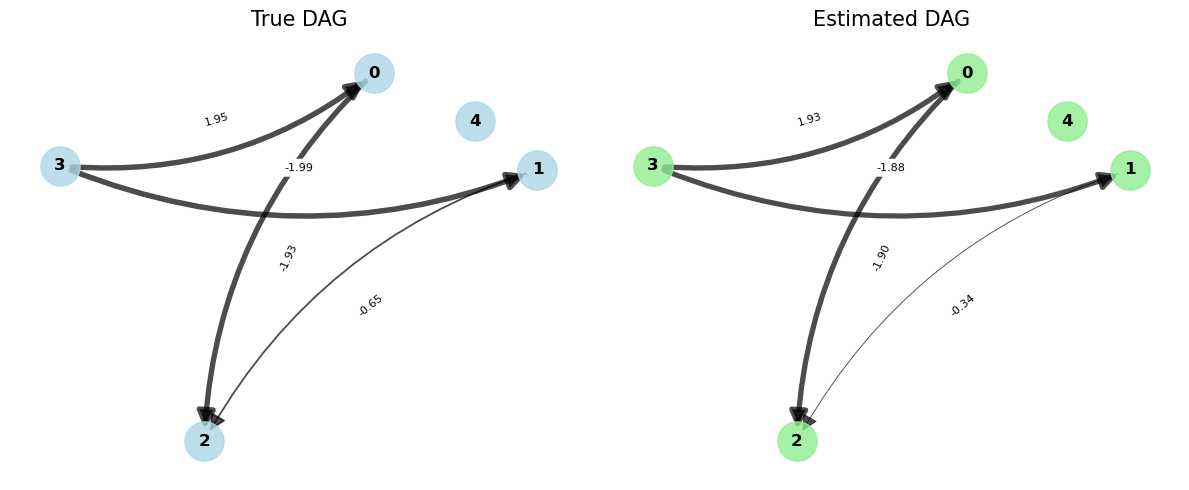

In [6]:
lambda1=0.05
loss_type='l2'
max_iter=100
h_tol=1e-8
rho_max=1e+16
w_threshold=0.3
estimated_A, time_taken_jax = notears_linear(X, lambda1, max_iter, h_tol, rho_max, w_threshold)
plot_dag_comparison(W_notears, estimated_A)

{'precision': np.float64(1.0),
 'recall': np.float64(1.0),
 'f1': np.float64(1.0),
 'true_edges': np.int64(4),
 'est_edges': np.int64(4),
 'true_positive': np.int64(4),
 'false_positive': np.int64(0),
 'false_negative': np.int64(0),
 'true_negative': np.int64(21),
 'shd': np.float64(0.0),
 'additions': np.int64(0),
 'deletions': np.int64(0),
 'reversals': np.float64(0.0)}

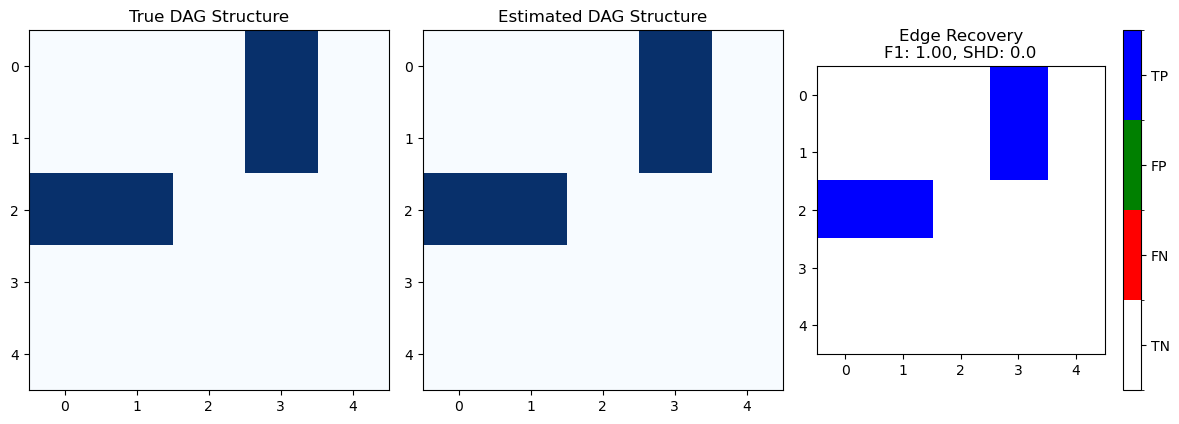

In [83]:
evaluate_reconstruction(W_notears, estimated_A)